In [1]:
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from imblearn.over_sampling import SMOTE
import shap

In [2]:
#Dataframe erstellen in dem Ergebnisse gespeichert werden
#Spaltennamen definieren
columns_df = ["Modell", "Accuracy", "Precision", "Recall", "F1-Score", "AUC"]
#Leeren Dataframe erstellen
ergebnisse = pd.DataFrame(columns=columns_df)

In [3]:
#Daten mit Label Encoding einlesen
Data = pd.read_csv('/home/RDC/petukhia.hub/H:/petukhia.hub/Masterarbeit_Dilara/LC_Data_Clean.csv',low_memory = False)

# Aufteilen der Daten in Features (X) und Zielvariable (y)
X = Data.drop('loan_status', axis=1)
y = Data['loan_status']

#Trainings und Test Datensatz erstellen
#10% der Daten als Testdaten
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 99)

In [4]:
# SMOTE anwenden
smote = SMOTE(random_state=42) #SMOTE Algorithmus definieren
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) #SMOTE auf Datensatz anwenden

#Klassengewichtung vor SMOTE
unique0, counts0 = np.unique(y_train, return_counts=True) #Anzahl und Features zählen
class_weights0 = dict(zip(unique0, counts0)) #Anzahl jeweiligem Feature zuordnen
print("Klassengewichte vor SMOTE:", class_weights0)

# Überprüfen der Klassengewichte nach der Anwendung von SMOTE
unique, counts = np.unique(y_train_resampled, return_counts=True)
class_weights = dict(zip(unique, counts))
print("Klassengewichte nach SMOTE:", class_weights)

Klassengewichte vor SMOTE: {0: 188592, 1: 45656}
Klassengewichte nach SMOTE: {0: 188592, 1: 188592}


In [5]:
#einfachen CART Algorithmus implementieren
baum = DecisionTreeClassifier(criterion='gini' , random_state=42) #Modell definieren
baum.fit(X_train_resampled, y_train_resampled) #Modell mit Daten trainieren

DecisionTreeClassifier(random_state=42)

In [6]:
modell = "CART + SMOTE"

#Genauigkeit prüfen
accuracy = baum.score(X_test, y_test)
print(f"Genauigkeit auf den Testdaten: {accuracy}")
#weitere Testmetriken berechnen auf Testdatensatz 
y_pred = baum.predict(X_test)
#Precision
precision = precision_score(y_test, y_pred)
print('Precision: ', precision)
# Berechnung des Recall
recall = recall_score(y_test, y_pred)
print('Recall: ', recall)
# Berechnung des F1-Scores
f1 = f1_score(y_test, y_pred)
print('F1: ', f1)
#Berechnung AUC 
y_probs = baum.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_probs)
print('AUC: ', auc)

#Ergebnisse zum Dataframe hinzufügen
ergebnisse.loc[0] = [modell, accuracy, precision, recall, f1, auc]

Genauigkeit auf den Testdaten: 0.696058091286307
Precision:  0.25604203152364274
Recall:  0.2852682926829268
F1:  0.26986617443470234
AUC:  0.5410219375676032


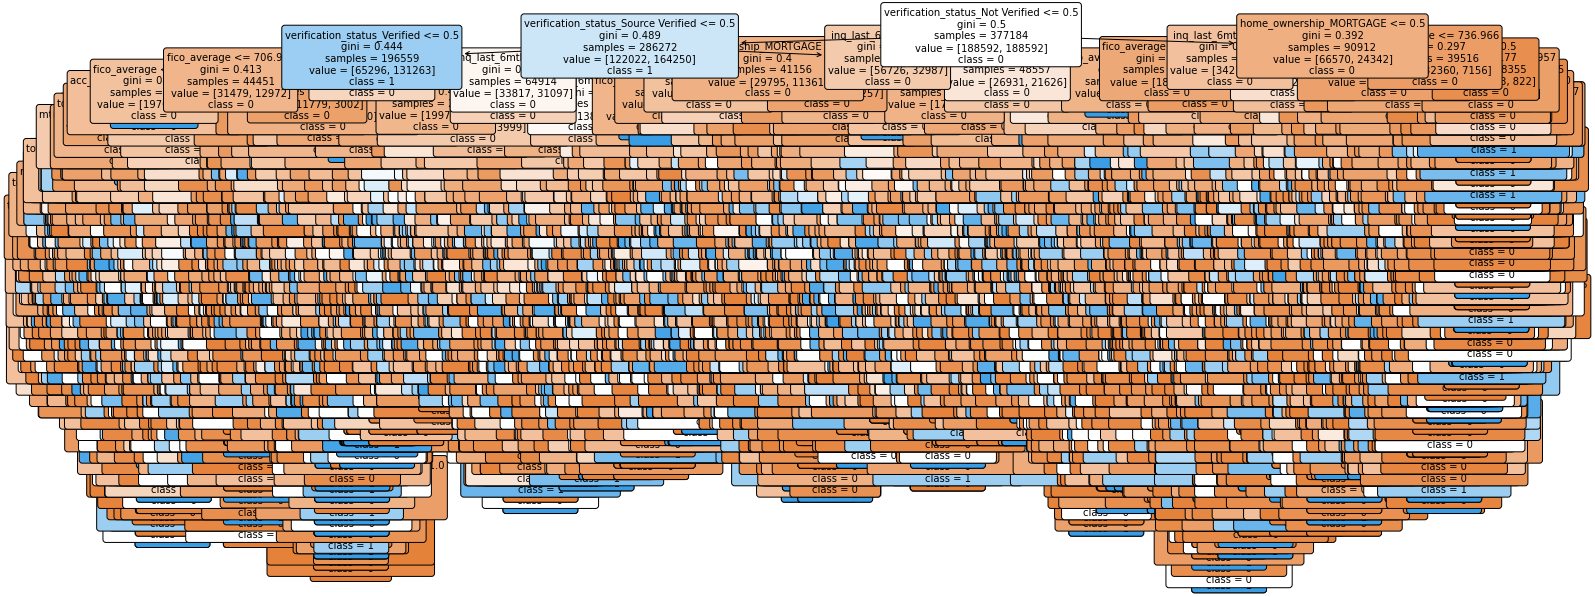

In [7]:
#Baum Graphisch darstellen
# Den Entscheidungsbaum graphisch darstellen
feature_names = X.columns.tolist()
fig, ax = plt.subplots(figsize=(25, 10))
tree.plot_tree(baum, feature_names=feature_names, class_names=['0', '1'], filled=True, rounded=True, fontsize=10)
plt.show()

## Random Forest

In [8]:
modell2 = "Random Forest"

# Random Forest Klassifikators definieren
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# Klassifikator auf den Trainingsdaten trainieren
rf_classifier.fit(X_train, y_train)

#Vorhersage machen
y_pred_rf = rf_classifier.predict(X_test)

# Bewertung der Leistung
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_rf)

#Precision
precision_rf = precision_score(y_test, y_pred_rf)
print('Precision: ', precision_rf)
# Berechnung des Recall
recall_rf = recall_score(y_test, y_pred_rf)
print('Recall: ', recall_rf)
# Berechnung des F1-Scores
f1_rf = f1_score(y_test, y_pred_rf)
print('F1: ', f1_rf)
#AUC
y_probs_rf = rf_classifier.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_probs_rf)
print('AUC: ', auc_rf)

#Ergebnisse zum Dataframe hinzufügen
ergebnisse.loc[1] = [modell2, accuracy_rf, precision_rf, recall_rf, f1_rf, auc_rf]

Accuracy: 0.8050560934378361
Precision:  0.5992217898832685
Recall:  0.030048780487804877
F1:  0.05722779635823114
AUC:  0.6906292923293775


In [9]:
#RF Modell mit ausgeglichenem Datensatz
modell3 = "Random Forest + SMOTE"

# Random Forest Klassifikators definieren
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 3 )
# Klassifikator auf den Trainingsdaten trainieren
rf_smote.fit(X_train_resampled, y_train_resampled)

y_pred_rf_smote = rf_smote.predict(X_test)

# Bewertung der Leistung
accuracy_rf_smote = accuracy_score(y_test, y_pred_rf_smote)
print("Accuracy:", accuracy_rf_smote)

#Precision
precision_rf_smote = precision_score(y_test, y_pred_rf_smote)
print('Precision: ', precision_rf_smote)
# Berechnung des Recall
recall_rf_smote = recall_score(y_test, y_pred_rf_smote)
print('Recall: ', recall_rf_smote)
# Berechnung des F1-Scores
f1_rf_smote = f1_score(y_test, y_pred_rf_smote)
print('F1: ', f1_rf_smote)
#AUC
y_probs_smote = rf_smote.predict_proba(X_test)[:, 1]
auc_smote = roc_auc_score(y_test, y_probs_smote)
print('AUC: ', auc_smote)

#Ergebnisse zum Dataframe hinzufügen
ergebnisse.loc[2] = [modell3, accuracy_rf_smote, precision_rf_smote, recall_rf_smote, f1_rf_smote, auc_smote]

Accuracy: 0.6849930843706777
Precision:  0.2712797619047619
Recall:  0.3557073170731707
F1:  0.307809202195019
AUC:  0.6035211610423523


In [10]:
#Hyperparameter optimieren mittels Grid Search

#Hyperparameter festlegen
param_distribution = {
    'n_estimators': [10, 50, 100, 200],       # Anzahl der Bäume
    'max_features': ['auto', 'sqrt', 'log2'],       # Anzahl der Features bei jeder Aufspaltung
    'max_depth': [None, 10, 20, 30],            # Maximale Tiefe des Baums
    'min_samples_split': [2,5, 10],    # Minimale Anzahl von Samples benötigt, um einen Knoten zu spalten
    'min_samples_leaf':[1, 2, 4, 10],     # Minimale Anzahl von Samples für einen Blattknoten
    'bootstrap': [True, False]              # Methode für das Ziehen von Samples für das Training jedes Baums
}

#Modell initialisieren
rf_best = RandomForestClassifier(random_state=42)

#Grid Search initialisieren
grid_search = GridSearchCV(
    estimator=rf_best,
    param_grid=param_distribution,
    cv=3,                          # 3-fache Kreuzvalidierung
    verbose=2,                     # Anzeige von Log-Nachrichten
    n_jobs=-1                      # Verwenden Sie alle CPU-Kerne
)

#Grid Search durchführen
grid_search.fit(X_train_resampled, y_train_resampled)

#Parameter ausgeben lassen
best_params = grid_search.best_params_
print("Beste Hyperparameter:", best_params)

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 5.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=  34.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=10; total time=  37.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time= 2.3min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time= 4.4min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=  29.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_esti

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=  36.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 5.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 9.1min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 5.4min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time= 2.0min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=10; total time=  31.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time= 2.5min
[CV] END bootstrap=True, max_dep

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=  36.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time= 2.8min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=11.1min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time= 3.0min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=  34.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=11.5min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=  28.3s
[CV] END bootstrap=True, max_depth=None

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time= 2.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 5.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=10.6min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 4.9min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time= 9.7min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=50; total time= 1.2min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=  24.5s
[CV] END bootstrap=True, max_depth

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 5.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=  32.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 9.4min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=  24.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=  42.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=  35.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 5.1min
[CV] END bootstrap=True, max_depth

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=  20.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=  36.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=  31.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time= 2.3min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=  25.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=  23.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time= 2.3min
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=  35.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 4.8min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time= 2.4min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=10; total time=  28.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=50; total time= 2.3min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=10.9min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time= 4.2min
[CV] END bootstrap=True, max_depth

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time= 2.4min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=10.2min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=10.5min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 2.3min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time= 1.8min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time= 2.0min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 3.2min
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 4.7min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 5.4min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=  30.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 5.0min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time= 2.6min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 9.7min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=  22.5s
[CV] END bootstrap=True, max_depth

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 2.7min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=  31.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 4.7min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=50; total time= 2.9min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=  33.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 4.8min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=  31.1s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time= 2.6min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 8.7min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time= 2.4min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 5.3min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time= 2.5min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time= 5.4min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=  24.7s
[CV] END bootstrap=True, max_depth

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 5.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=  31.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=10.0min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time= 2.4min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 4.4min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time= 3.0min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time= 2.1min
[CV] END bootstrap=True, max_dep

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=10.2min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 2.6min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=10.1min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=  22.7s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 1.8min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 7.5min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time= 3.4min
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=10.1min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=  41.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 9.5min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time= 5.1min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time= 2.1min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 7.4min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 5.5min
[CV] END bootstrap=True, max_depth=1

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=  40.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 8.7min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=10; total time=  26.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time= 9.8min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=10.2min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=  12.4s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time= 1.4min
[CV] END bootstrap=True, max_dep

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=10.1min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=  27.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 5.2min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 5.3min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=10; total time=  18.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=50; total time= 2.3min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 8.0min
[CV] END bootstrap=True, max_depth

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time= 2.6min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=  30.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time= 2.3min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 4.5min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time= 9.6min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 9.4min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=  25.0s
[CV] END bootstrap=True, max_dept

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=10.6min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 9.9min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time= 8.8min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 8.0min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=  18.7s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time= 1.7min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 6.1min
[CV] END bootstrap=True, max_depth=10, 

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=  40.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=10.6min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time= 2.7min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 9.9min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 7.4min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=10; total time=  24.5s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time= 1.6min
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time= 3.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time= 2.3min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 5.4min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=  33.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=10.8min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=10; total time=  35.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time= 7.9min
[CV] END bootstrap=True, max_dept

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 5.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 9.4min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=  31.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=10.1min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 8.0min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=10; total time=  18.1s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time= 7.2min
[CV] END bootstrap=True, max_dep

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=11.5min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=10.1min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=10.3min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time= 6.8min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 5.8min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=  24.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 5.8min
[CV] END bootstrap=True, max_depth=10, 

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=  30.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=  37.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=  27.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time= 2.9min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time= 2.8min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time= 8.8min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 9.9min
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=  39.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=10.7min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 4.7min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 9.8min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 6.7min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time= 7.9min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time= 1.8min
[CV] END bootstrap=True, max_depth

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 6.9min
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time= 3.3min
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=10; total time=  31.1s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=12.6min
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time= 2.9min
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time= 5.9min
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=  25.2s
[CV] END bootstrap=False, max_depth=20

[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time= 2.2min
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=  29.4s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 5.2min
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=10; total time=  33.0s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time= 7.6min
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=14.7min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=  32.2s
[CV] END bootstrap=False, max_depth=30, m

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 4.4min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=10; total time=  34.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time= 9.5min
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=10; total time=  13.0s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time= 2.7min
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 6.0min
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=13.5min
[CV] END bootstrap=False, max_depth=20

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 5.6min
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=12.6min
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=13.5min
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time= 1.9min
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=10; total time=  24.3s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time= 4.5min
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=  38.6s
[CV] END bootstrap=False, max_depth=3

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=14.1min
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=  36.2s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time= 2.7min
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=10.0min
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 7.1min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=15.0min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=50; total time= 3.7min
[CV] END bootstrap=False, max_depth=30, 

[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=  34.5s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 4.3min
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=  21.9s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time= 1.6min
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=  34.0s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time= 1.9min
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=  25.8s
[CV] END bootstrap=False, max_depth=20, max_fe

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=  28.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time= 3.2min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=  51.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=13.9min
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=  30.3s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 8.5min
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 8.6min
[CV] END bootstrap=False, max_depth=30, max

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=  26.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 3.9min
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.8min
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=  18.1s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 2.7min
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=  40.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=  35.9s
[CV] END bootstrap=False, max_depth=20, max

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time= 3.3min
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 6.5min
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=  47.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 6.5min
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=  13.7s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time= 2.4min
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 4.3min
[CV] END bootstrap=False, max_depth=20, max

Beste Hyperparameter: {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [11]:
modell4 = "Random Forest + SMOTE +\nHyperparameter"

# Startzeit messen
start_time = time.time()

rf_best = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                max_features=best_params['max_features'],
                                max_depth=best_params['max_depth'],
                                min_samples_split=best_params['min_samples_split'],
                                min_samples_leaf=best_params['min_samples_leaf'],
                                bootstrap=best_params['bootstrap'],
                                random_state=42)

rf_best.fit(X_train_resampled, y_train_resampled)

# Endzeit messen
end_time = time.time()

# Bewertung des Modells auf den Testdaten
accuracy_best = rf_best.score(X_test, y_test)
print("Genauigkeit auf Testdaten:", accuracy_best)

#Vorhersage mit Modell treffen
y_pred_rf_best = rf_best.predict(X_test)

#weitere Testmetriken berechnen
#Precision
precision_rf_best = precision_score(y_test, y_pred_rf_best)
print('Precision: ', precision_rf_best)
# Berechnung des Recall
recall_rf_best = recall_score(y_test, y_pred_rf_best)
print('Recall: ', recall_rf_best)
# Berechnung des F1-Scores
f1_rf_best = f1_score(y_test, y_pred_rf_best)
print('F1: ', f1_rf_best)

# Gesamtrechenzeit berechnen und ausgeben
elapsed_time = end_time - start_time
print(f"Gesamtrechenzeit: {elapsed_time} Sekunden")

Genauigkeit auf Testdaten: 0.8039034885507914
Precision:  0.5695364238410596
Recall:  0.01678048780487805
F1:  0.032600454890068235
Gesamtrechenzeit: 587.1633245944977 Sekunden


Text(0.5, 1.0, 'Confusion Matrix für Random Forest')

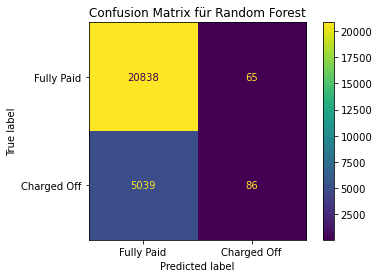

In [12]:
#Confusion Matrix berechnen
cm = confusion_matrix(y_test, y_pred_rf_best, labels=rf_best.classes_) #confusionmatrix für Testdaten berecnen
disp = ConfusionMatrixDisplay(confusion_matrix=cm, #Confusion Matrix plotten
                               display_labels=["Fully Paid", "Charged Off"]) #Labels beschriften

disp.plot()
plt.title('Confusion Matrix für Random Forest') #Überschrift festlegen

AUC:  0.6810137137509729


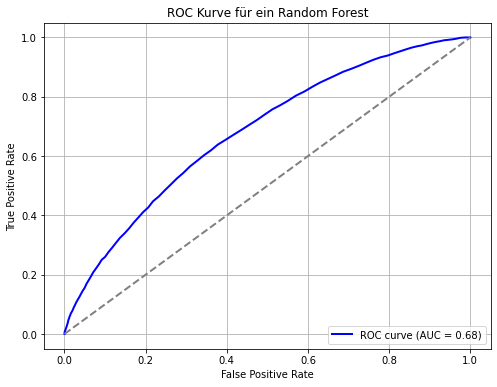

In [13]:
#ROC Curve 

# ROC-Kurve berechnen
y_probs_best = rf_best.predict_proba(X_test)[:, 1]
roc_auc_best = roc_auc_score(y_test, y_probs_best)
fpr, tpr, thresholds = roc_curve(y_test, y_probs_best)

print('AUC: ', roc_auc_best)

#Ergebnisse zum Dataframe hinzufügen
ergebnisse.loc[3] = [modell4, accuracy_best, precision_rf_best, recall_rf_best, f1_rf_best, roc_auc_best]

# ROC-Kurve plotten
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Kurve für ein Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

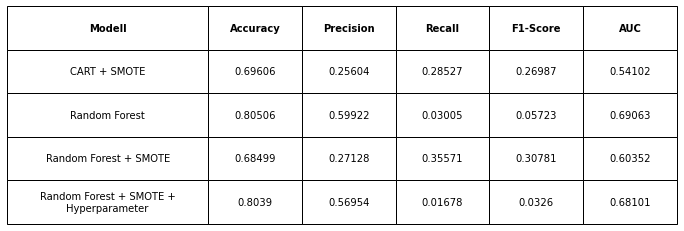

In [14]:
# Numerische Spalten auf 5 Nachkommastellen begrenzen
numerical_cols = ergebnisse.select_dtypes(include=['float64']).columns
ergebnisse[numerical_cols] = ergebnisse[numerical_cols].round(5)

# Tabelle erstellen
fig, ax = plt.subplots(figsize=(12, 4))  # Figur und Achsen erstellen
ax.axis('off')  # Achsen ausschalten

# Spaltenbreiten festlegen
col_widths = [0.3] + [0.14 for _ in range(ergebnisse.shape[1] - 1)]

# Tabellendiagramm erstellen
table = ax.table(cellText=ergebnisse.values, colLabels=ergebnisse.columns, cellLoc='center', loc='center', bbox=[0, 0, 1, 1], colWidths=col_widths)

# Überschriften fett drucken
table.auto_set_font_size(False)
table.set_fontsize(10)  # Schriftgröße anpassen, falls gewünscht
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_text_props(fontweight='bold')  # Überschrift fett drucken

plt.show()

## Modell erklären mit SHAP Values

In [16]:
explainer = shap.TreeExplainer(rf_best) #SHAP Explainer erstellen
#X_train hier nicht benötigt da direkt auf Struktur vom Baum zurück gegriffen werden kann
shap_values = explainer.shap_values(X_test) #SHAP Werte berechnen

In [ ]:
#SHAP Values visualisieren

#Zusammenfassungsplot
#Zeigt die wichtigsten Merkmale in absteigender Reihenfolge
shap.summary_plot(shap_values, X_test)

In [ ]:
#Zufällige Beobachtung aus dem Testdatensatz wählen der nicht ausgefallen ist
zufaellige_zeile0 = y_test[y_test == 0].sample(n=1)
zeilenindex0 = zufaellige_zeile0.index[0]
print("Zeilenindex Not Defaulted:", zeilenindex0)

#Zeilenindex verwenden, um die entsprechende Zeile aus X_test auszuwählen
zeile_X_test0 = X_test.loc[zeilenindex0]
print(zeile_X_test0)

In [ ]:
shap_values0 = explainer.shap_values(zeile_X_test0)  # Shap values kalkulieren

# Anzahl der anzuzeigenden Features
top_n = 5

# Feature-Namen aus dem Datensatz extrahieren
feature_names = X_test.columns.to_numpy()  # Als numpy-Array

# SHAP-Werte und Feature-Namen sortieren
shap_values0_array = np.array(shap_values0[1])  # Als numpy-Array (angenommen, dass der Index 1 das richtige Element ist)
sorted_indices = np.argsort(np.abs(shap_values0_array))[::-1]
top_indices = sorted_indices[:top_n]

# Top SHAP-Werte und zugehörige Feature-Namen auswählen
top_shap_values = shap_values0_array[top_indices]
top_features = feature_names[top_indices]

# Initialisiere JavaScript für SHAP-Plots
shap.initjs()

# force plot für top_n Features erstellen
shap.force_plot(explainer.expected_value[1], top_shap_values, zeile_X_test0[top_features])

In [ ]:
#Zufällige Beobachtung aus dem Testdatensatz wählen der ausgefallen ist
zufaellige_zeile1 = y_test[y_test == 1].sample(n=1)
zeilenindex1 = zufaellige_zeile1.index[0]
print("Zeilenindex Defaulted:", zeilenindex1)

#Zeilenindex verwenden, um die entsprechende Zeile aus X_test auszuwählen
zeile_X_test1 = X_test.loc[zeilenindex1]
print(zeile_X_test1)

In [ ]:
shap_values1 = explainer.shap_values(zeile_X_test1)  # Shap values kalkulieren

# Anzahl der anzuzeigenden Features
top_n = 5

# Feature-Namen aus dem Datensatz extrahieren
feature_names = X_test.columns.to_numpy()  # Als numpy-Array

# SHAP-Werte und Feature-Namen sortieren
shap_values1_array = np.array(shap_values1[1])  # Als numpy-Array (angenommen, dass der Index 1 das richtige Element ist)
sorted_indices = np.argsort(np.abs(shap_values1_array))[::-1]
top_indices = sorted_indices[:top_n]

# Top SHAP-Werte und zugehörige Feature-Namen auswählen
top_shap_values1 = shap_values1_array[top_indices]
top_features1 = feature_names[top_indices]

# Initialisiere JavaScript für SHAP-Plots
shap.initjs()

# force plot für top_n Features erstellen
shap.force_plot(explainer.expected_value[1], top_shap_values1, zeile_X_test1[top_features1])